# Hypothese 7

In [ ]:
import json
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy import stats
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# Setze Random Seed für Reproduzierbarkeit
np.random.seed(42)

# Hohe Qualitätseinstellungen für Publikationen
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica']
mpl.style.use('seaborn-v0_8-whitegrid')

## Daten einlesen

In [3]:
parquet_file = "data/input/Data_OpenAlex.parquet"
parquet_dataset = pq.ParquetFile(parquet_file)

In [4]:
def analyze_company_involvement_efficiently(parquet_dataset):
    chunk_size = 20000000 
    
    company_papers_fwci = []
    non_company_papers_fwci = []
    
    total_papers = 0
    valid_papers = 0
    papers_with_company = 0
    papers_without_company = 0
    chunk_num = 0
    
    # Fehlerbehandlung für JSON-Parsing
    def safe_parse_institutions(institutions_str):
        """Sichere JSON-Parsing für Institutions-Spalte"""
        try:
            if pd.isna(institutions_str) or institutions_str == '[]' or institutions_str == '':
                return []
            
            # Falls es bereits eine Liste ist
            if isinstance(institutions_str, list):
                return institutions_str
            
            # JSON String parsen
            institutions = json.loads(institutions_str)
            return institutions if isinstance(institutions, list) else []
        except:
            return []
    
    def check_company_involvement(institutions_list):
        """Prüfe ob mindestens eine Institution vom Typ 'company' dabei ist"""
        for institution in institutions_list:
            if isinstance(institution, dict) and institution.get('type') == 'company':
                return True
        return False
    
    total_rows = parquet_dataset.metadata.num_rows
    
    print(f"Gesamtdatei: {total_rows:,} Zeilen")
    print(f"Chunk-Größe: {chunk_size:,} Zeilen")
    print(f"Erwartete Chunks: {total_rows // chunk_size + 1}")
    
    for batch in parquet_dataset.iter_batches(batch_size=chunk_size):
        chunk_num += 1
        
        # Konvertiere zu Pandas DataFrame
        df_chunk = batch.to_pandas()
        total_papers += len(df_chunk)
        
        # Filtere nur Zeilen mit gültigen FWCI-Werten und Institutions-Daten
        df_valid = df_chunk.dropna(subset=['fwci', 'institutions'])
        df_valid = df_valid[df_valid['fwci'] != 0] 
        
        valid_papers += len(df_valid)
        
        for _, row in df_valid.iterrows():
            # Parse Institutions JSON
            institutions = safe_parse_institutions(row['institutions'])
            
            # Prüfe Companybeteiligung
            has_company = check_company_involvement(institutions)
            
            fwci_value = row['fwci']
            
            # Gruppiere FWCI-Werte
            if has_company:
                company_papers_fwci.append(fwci_value)
                papers_with_company += 1
            else:
                non_company_papers_fwci.append(fwci_value)
                papers_without_company += 1
        
        # Progress Update
        if chunk_num % 5 == 0:
            progress = (chunk_num * chunk_size) / total_rows * 100
            print(f"   Chunk {chunk_num:2d}: {progress:5.1f}% | "
                    f"Valid: {valid_papers:,} | Mit Company: {papers_with_company:,} | Ohne Company: {papers_without_company:,}")
    
    print(f"\nGesamte Papers: {total_papers:,}")
    print(f"Gültige Papers (mit FWCI & Institutions): {valid_papers:,}")
    print(f"Papers mit Companybeteiligung: {papers_with_company:,}")
    print(f"Papers ohne Companybeteiligung: {papers_without_company:,}")
    print(f"Company-Beteiligungsrate: {papers_with_company/(papers_with_company + papers_without_company)*100:.1f}%")
    
    return (np.array(company_papers_fwci), np.array(non_company_papers_fwci), 
            papers_with_company, papers_without_company)

company_fwci, non_company_fwci, total_with_company, total_without_company = analyze_company_involvement_efficiently(parquet_dataset)

Gesamtdatei: 16,751,942 Zeilen
Chunk-Größe: 1,000,000 Zeilen
Erwartete Chunks: 17
   ⏳ Chunk  5:  29.8% | Valid: 3,050,377 | Mit Company: 166,096 | Ohne Company: 2,884,281
   ⏳ Chunk 10:  59.7% | Valid: 5,823,555 | Mit Company: 326,841 | Ohne Company: 5,496,714
   ⏳ Chunk 15:  89.5% | Valid: 8,685,950 | Mit Company: 475,591 | Ohne Company: 8,210,359

Gesamte Papers: 16,751,942
Gültige Papers (mit FWCI & Institutions): 9,231,443
Papers mit Companybeteiligung: 507,967
Papers ohne Companybeteiligung: 8,723,476
Company-Beteiligungsrate: 5.5%


In [5]:
print(f"Datensammlung abgeschlossen!")
print(f"Company FWCI-Werte: {len(company_fwci):,}")
print(f"Non-Company FWCI-Werte: {len(non_company_fwci):,}")
print(f"Die detaillierte Visualisierung erfolgt in der nächsten Zelle.")

Datensammlung abgeschlossen!
Company FWCI-Werte: 507,967
Non-Company FWCI-Werte: 8,723,476
Die detaillierte Visualisierung erfolgt in der nächsten Zelle.


In [6]:
print(f"Datenübersicht:")
print(f"   Company Papers: {len(company_fwci):,}")
print(f"   Nicht-Company Papers: {len(non_company_fwci):,}")

Datenübersicht:
   Company Papers: 507,967
   Nicht-Company Papers: 8,723,476


In [22]:
original_company = company_fwci.copy()
original_non_company = non_company_fwci.copy()

## Vorbereitung für Visualisierung

In [23]:
def sample_for_visualization(data, max_samples=50000):
    """Sampling, das die Verteilung erhält"""
    if len(data) <= max_samples:
        return data
    
    # Stratifiziertes Sampling basierend auf Quantilen
    data_array = np.array(data)
    
    # Definiere Quantil-Bereiche
    quantiles = np.percentile(data_array, [0, 10, 25, 50, 75, 90, 95, 99, 99.5, 100])
    
    sampled_data = []
    total_samples = 0
    
    # Verschiedene Sampling-Raten für verschiedene Bereiche
    sampling_rates = [0.1, 0.15, 0.2, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02] 
    
    for i in range(len(quantiles)-1):
        lower = quantiles[i]
        upper = quantiles[i+1]
        
        # Finde Daten in diesem Bereich
        mask = (data_array >= lower) & (data_array <= upper)
        range_data = data_array[mask]
        
        if len(range_data) > 0:
            # Berechne Anzahl Samples für diesen Bereich
            target_samples = int(len(range_data) * sampling_rates[i])
            target_samples = min(target_samples, len(range_data))
            target_samples = max(target_samples, 1)  # Mindestens 1 Sample
            
            # Zufälliges Sampling innerhalb des Bereichs
            if target_samples < len(range_data):
                sampled_indices = np.random.choice(len(range_data), target_samples, replace=False)
                sampled_range = range_data[sampled_indices]
            else:
                sampled_range = range_data
            
            sampled_data.extend(sampled_range.tolist())
            total_samples += len(sampled_range)
    
    return sampled_data

# Erweiterte Samplingfunktion für statistische Analyse
def smart_sample_for_statistics(data, target_samples=25000):
    """Erweiterte Sampling-Funktion für robuste statistische Tests"""
    if len(data) <= target_samples:
        return data
    
    data_array = np.array(data)
    
    # Multi-Level Stratified Sampling
    # Level 1, Quartile
    q1, q2, q3 = np.percentile(data_array, [25, 50, 75])
    
    # Level 2, Dezile innerhalb der Quartile
    sampled_data = []
    
    # Quartil 1 (0-25%)
    q1_data = data_array[data_array <= q1]
    q1_samples = min(int(target_samples * 0.25), len(q1_data))
    if q1_samples > 0:
        sampled_data.extend(np.random.choice(q1_data, q1_samples, replace=False))
    
    # Quartil 2 (25-50%)
    q2_data = data_array[(data_array > q1) & (data_array <= q2)]
    q2_samples = min(int(target_samples * 0.25), len(q2_data))
    if q2_samples > 0:
        sampled_data.extend(np.random.choice(q2_data, q2_samples, replace=False))
    
    # Quartil 3 (50-75%)
    q3_data = data_array[(data_array > q2) & (data_array <= q3)]
    q3_samples = min(int(target_samples * 0.25), len(q3_data))
    if q3_samples > 0:
        sampled_data.extend(np.random.choice(q3_data, q3_samples, replace=False))
    
    # Quartil 4 (75-100%)
    q4_data = data_array[data_array > q3]
    q4_samples = min(int(target_samples * 0.25), len(q4_data))
    if q4_samples > 0:
        sampled_data.extend(np.random.choice(q4_data, q4_samples, replace=False))
    
    return sampled_data

# Bereinigte Daten für Visualisierung (entferne nur extreme Ausreißer > 99.8%)
def remove_extreme_outliers(data, threshold=99.8):
    """Entferne nur die extremsten Ausreißer (oberste 0.2%)"""
    if len(data) == 0:
        return data
    percentile = np.percentile(data, threshold)
    return [x for x in data if x <= percentile]

In [29]:
# Erstelle Smart-Samples für statistische Analyse
company_stats_sample = smart_sample_for_statistics(original_company, 507967)
non_company_stats_sample = smart_sample_for_statistics(original_non_company, 507967)

# Verwende intelligentes Sampling für Visualisierung
company_cleaned = remove_extreme_outliers(original_company)
non_company_cleaned = remove_extreme_outliers(original_non_company)

# Smart Sampling für Performance bei sehr großen Datenmengen
if len(company_cleaned) > 50000:
    company_cleaned = sample_for_visualization(company_cleaned, 507967)
if len(non_company_cleaned) > 50000:
    non_company_cleaned = sample_for_visualization(non_company_cleaned, 507967)

print(f"Datenverwendung:")
print(f"   Company Original: {len(original_company):,}")
print(f"   Company Statistik-Sample: {len(company_stats_sample):,}")
print(f"   Company Visualisierung: {len(company_cleaned):,}")
print(f"   Non-Company Original: {len(original_non_company):,}")
print(f"   Non-Company Statistik-Sample: {len(non_company_stats_sample):,}")
print(f"   Non-Company Visualisierung: {len(non_company_cleaned):,}")

Datenverwendung:
   Company Original: 507,967
   Company Statistik-Sample: 507,967
   Company Visualisierung: 506,951
   Non-Company Original: 8,723,476
   Non-Company Statistik-Sample: 507,964
   Non-Company Visualisierung: 1,629,400


In [30]:
# DataFrame für bereinigten Plot erstellen
plot_df = pd.DataFrame({
    'Institution': ['Mit Company-Beteiligung']*len(company_cleaned) + ['Ohne Company-Beteiligung']*len(non_company_cleaned),
    'FWCI': company_cleaned + non_company_cleaned,
    'Kategorie': ['Anzahl der Paper'] * (len(company_cleaned) + len(non_company_cleaned))
})

# Berechne Durchschnittswerte für die bereinigten Daten
company_mean = np.mean(company_cleaned)
non_company_mean = np.mean(non_company_cleaned)

print(f"Durchschnittswerte (bereinigte Daten):")
print(f"   Mit Company-Beteiligung: {company_mean:.3f}")
print(f"   Ohne Company-Beteiligung: {non_company_mean:.3f}")
print(f"   Differenz: {company_mean - non_company_mean:.3f}")

Durchschnittswerte (bereinigte Daten):
   Mit Company-Beteiligung: 2.516
   Ohne Company-Beteiligung: 2.007
   Differenz: 0.509


## Visualisierung erstellen

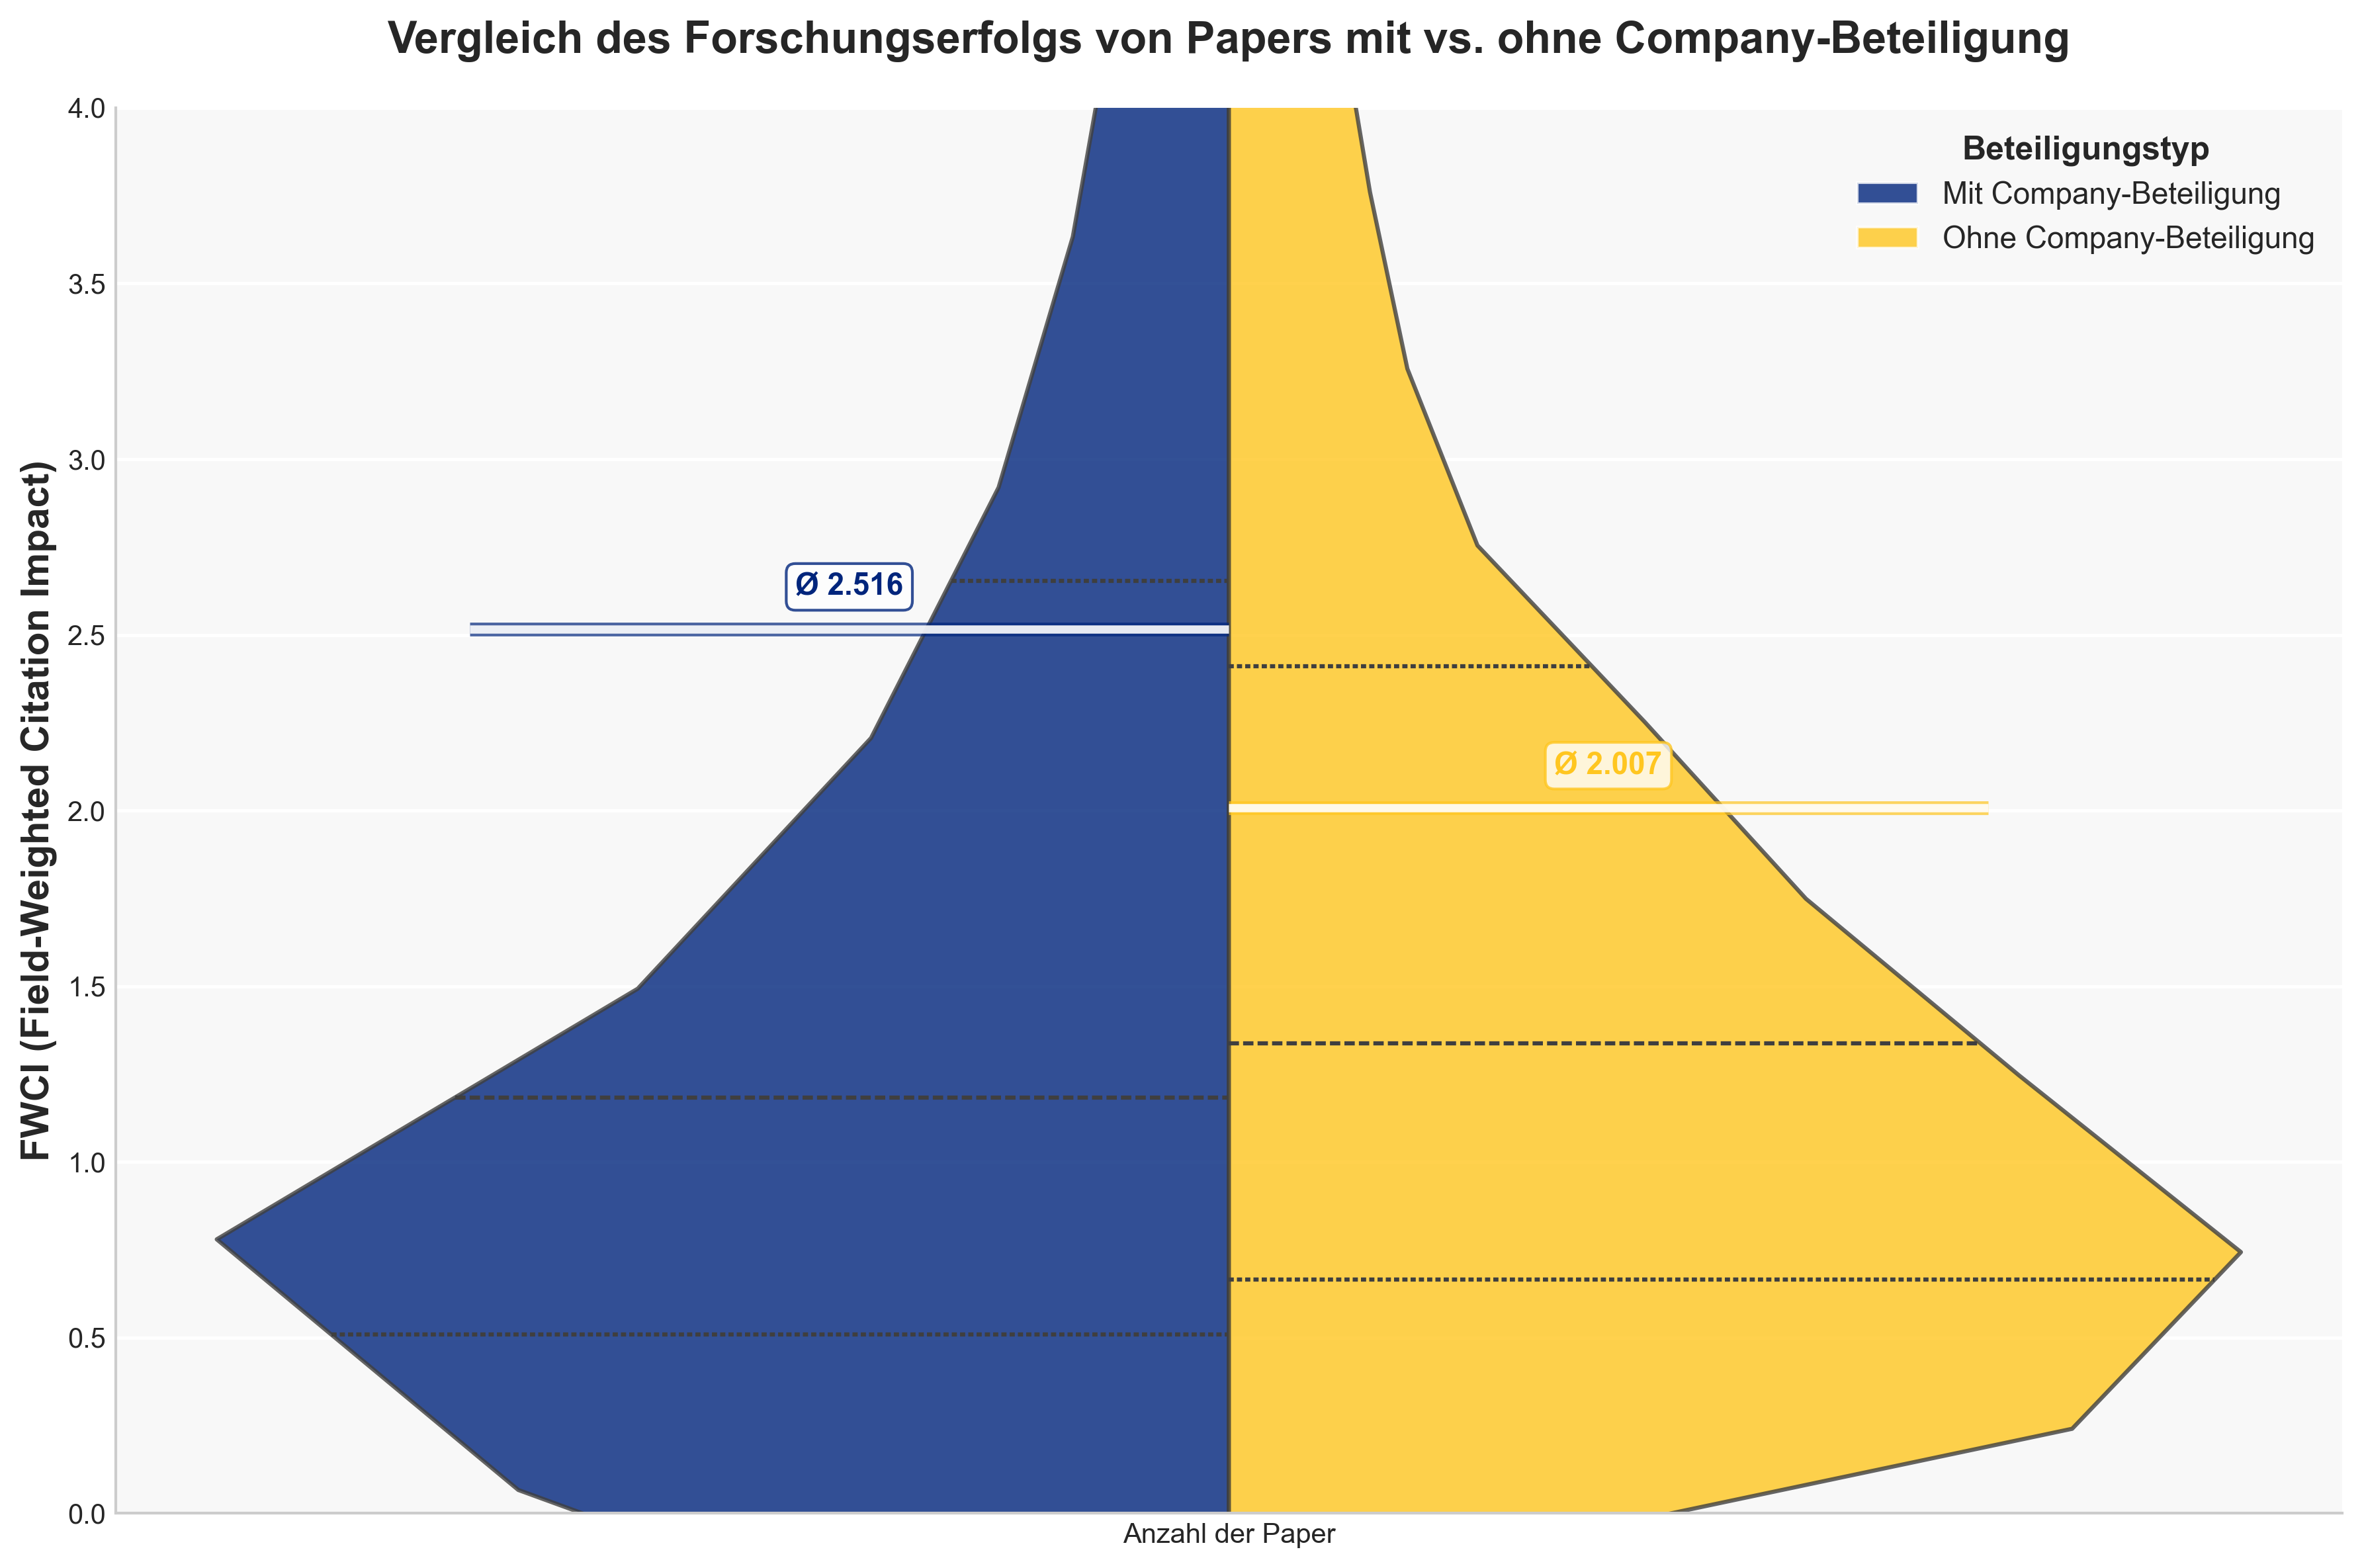

In [31]:
# Publikationsqualitäts Farbpalette (gleiche Farben wie Hypothese 3)
base_colors = {
    'Mit Company-Beteiligung': '#00257C',  # Dunkelblau
    'Ohne Company-Beteiligung': '#FFC620',  # Orange/Gelb
}

plt.figure(figsize=(12, 8), dpi=300)
ax = plt.axes()

# Hintergrund anpassen
ax.set_facecolor('#f8f8f8')
ax.grid(color='white', linestyle='-', linewidth=1.2)
ax.set_axisbelow(True)  # Grid hinter den Daten

# Violin Plot erstellen
violin_plot = sns.violinplot(
    data=plot_df,
    x='Kategorie',
    y='FWCI',
    hue='Institution',
    split=True,
    inner='quartile',
    linewidth=1.5,
    ax=ax
)

# Farben anpassen
for i, collection in enumerate(ax.collections):
    if i % 2 == 0:  # Company
        collection.set_facecolor(base_colors['Mit Company-Beteiligung'])
        collection.set_alpha(0.8)
    else:  # Non-Company
        collection.set_facecolor(base_colors['Ohne Company-Beteiligung'])
        collection.set_alpha(0.8)

# Y-Achsenlimit zuerst festlegen für korrekte Positionierung
data_max = max(max(company_cleaned), max(non_company_cleaned))
y_upper_limit = min(data_max * 1.05, 4.0)  # Weniger Whitespace, niedrigeres Limit
plt.ylim(0, y_upper_limit)

# Durchschnittswerte als horizontale Linien hinzufügen
# Position der Violin-Plots bestimmen
x_pos = 0  # Da wir nur eine Kategorie haben
violin_width = 0.3  # Typische Breite der Violinhälften

# Company-Durchschnitt (linke Seite)
company_line = ax.hlines(y=company_mean, xmin=x_pos-violin_width, xmax=x_pos, 
                        colors='white', linewidth=3, linestyles='-', alpha=0.9, zorder=10)
company_line_border = ax.hlines(y=company_mean, xmin=x_pos-violin_width, xmax=x_pos, 
                                colors=base_colors['Mit Company-Beteiligung'], linewidth=5, linestyles='-', alpha=0.7, zorder=9)

# Nicht-Company-Durchschnitt (rechte Seite)
non_company_line = ax.hlines(y=non_company_mean, xmin=x_pos, xmax=x_pos+violin_width, 
                            colors='white', linewidth=3, linestyles='-', alpha=0.9, zorder=10)
non_company_line_border = ax.hlines(y=non_company_mean, xmin=x_pos, xmax=x_pos+violin_width, 
                                    colors=base_colors['Ohne Company-Beteiligung'], linewidth=5, linestyles='-', alpha=0.7, zorder=9)

# Berechne optimale Text-Positionen basierend auf Y-Achsen-Limit
text_offset = y_upper_limit * 0.02  # 2% vom oberen Limit als Offset

# Durchschnittswerte als Text hinzufügen (nur wenn sie im sichtbaren Bereich sind)
if company_mean + text_offset < y_upper_limit * 0.95:
    ax.text(x_pos-violin_width/2, company_mean + text_offset, f'Ø {company_mean:.3f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold', 
            color=base_colors['Mit Company-Beteiligung'], 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=base_colors['Mit Company-Beteiligung']))

if non_company_mean + text_offset < y_upper_limit * 0.95:
    ax.text(x_pos+violin_width/2, non_company_mean + text_offset, f'Ø {non_company_mean:.3f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold', 
            color=base_colors['Ohne Company-Beteiligung'],
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=base_colors['Ohne Company-Beteiligung']))

# Beschriftungen und Stil
plt.title("Vergleich des Forschungserfolgs von Papers mit vs. ohne Company-Beteiligung", 
            fontsize=16, fontweight='bold', pad=20)  # Reduziertes Padding
plt.ylabel("FWCI (Field-Weighted Citation Impact)", fontsize=14, fontweight='bold')
plt.xlabel("", fontsize=12)

# Achsen anpassen
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)

# Benutzerdefinierte Legende
legend_elements = [
    Patch(facecolor=base_colors['Mit Company-Beteiligung'], edgecolor='white', alpha=0.8, 
            label=f'Mit Company-Beteiligung'),
    Patch(facecolor=base_colors['Ohne Company-Beteiligung'], edgecolor='white', alpha=0.8,
            label=f'Ohne Company-Beteiligung')
]

legend = plt.legend(handles=legend_elements, loc='upper right', 
                    title='Beteiligungstyp', framealpha=0.95, edgecolor='lightgray',
                    title_fontsize=12, fontsize=11)
plt.setp(legend.get_title(), fontweight='bold')
plt.tight_layout()

plot_base_path = "data/output/"
plt.savefig(f"{plot_base_path}Hypothese_7.svg", 
            format='svg', bbox_inches='tight')

plt.show()

In [ ]:
company_sample = np.array(company_stats_sample)
non_company_sample = np.array(non_company_stats_sample)

print(f"Sample Charakteristika")
print(f"   Company Sample: {len(company_sample):,} Datenpunkte")
print(f"   Non-Company Sample: {len(non_company_sample):,} Datenpunkte")
print(f"   Sampling-Rate Company: {len(company_sample)/len(original_company)*100:.2f}%")
print(f"   Sampling-Rate Non-Company: {len(non_company_sample)/len(original_non_company)*100:.2f}%")

Sample Charakteristika
   Company Sample: 507,967 Datenpunkte
   Non-Company Sample: 507,964 Datenpunkte
   Sampling-Rate Company: 100.00%
   Sampling-Rate Non-Company: 5.82%


## Deskriptive Statistik

In [37]:
def comprehensive_descriptive_stats(data, label):
    print(f"{label}:")
    print(f"      Anzahl: {len(data):,}")
    print(f"      Mittelwert: {np.mean(data):.4f}")
    print(f"      Median: {np.median(data):.4f}")
    print(f"      Modus: {stats.mode(data, keepdims=True)[0][0]:.4f}")
    print(f"      Standardabweichung: {np.std(data, ddof=1):.4f}")
    print(f"      Varianz: {np.var(data, ddof=1):.4f}")
    print(f"      Standardfehler: {stats.sem(data):.4f}")
    print(f"      Min: {np.min(data):.4f}")
    print(f"      Max: {np.max(data):.4f}")
    print(f"      Spannweite: {np.max(data) - np.min(data):.4f}")
    
    # Perzentile
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    percs = np.percentile(data, percentiles)
    print(f"      Perzentile:")
    for p, v in zip(percentiles, percs):
        print(f"         P{p:2d}: {v:.4f}")
    
    # Schiefe und Kurtosis
    print(f"      Schiefe (Skewness): {stats.skew(data):.4f}")
    print(f"      Kurtosis: {stats.kurtosis(data):.4f}")
    
    # Quartile und IQR
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    print(f"      Q1: {q1:.4f}")
    print(f"      Q3: {q3:.4f}")
    print(f"      IQR: {iqr:.4f}")
    
    # Ausreißer-Analyse (IQR-Methode)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"      Ausreißer (IQR-Methode): {len(outliers):,} ({len(outliers)/len(data)*100:.2f}%)")
    
    # Konfidenzintervall für den Mittelwert (95%)
    ci_lower, ci_upper = stats.t.interval(0.95, len(data)-1, 
                                            loc=np.mean(data), 
                                            scale=stats.sem(data))
    print(f"      95% KI Mittelwert: [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    return {
        'n': len(data),
        'mean': np.mean(data),
        'median': np.median(data),
        'std': np.std(data, ddof=1),
        'var': np.var(data, ddof=1),
        'sem': stats.sem(data),
        'min': np.min(data),
        'max': np.max(data),
        'q1': q1,
        'q3': q3,
        'iqr': iqr,
        'skewness': stats.skew(data),
        'kurtosis': stats.kurtosis(data),
        'outliers': len(outliers),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

In [38]:
non_company_stats = comprehensive_descriptive_stats(non_company_sample, "Ohne Company-Beteiligung")

Ohne Company-Beteiligung:
      Anzahl: 507,964
      Mittelwert: 2.5484
      Median: 1.1785
      Modus: 0.1760
      Standardabweichung: 9.7649
      Varianz: 95.3525
      Standardfehler: 0.0137
      Min: 0.0120
      Max: 4855.4458
      Spannweite: 4855.4338
      Perzentile:
         P 1: 0.0880
         P 5: 0.1640
         P10: 0.2400
         P25: 0.5138
         P50: 1.1785
         P75: 2.6043
         P90: 5.3537
         P95: 8.4448
         P99: 21.5670
      Schiefe (Skewness): 256.9755
      Kurtosis: 121099.5079
      Q1: 0.5138
      Q3: 2.6043
      IQR: 2.0905
      Ausreißer (IQR-Methode): 45,777 (9.01%)
      95% KI Mittelwert: [2.5215, 2.5752]


In [39]:
company_stats = comprehensive_descriptive_stats(company_sample, "Mit Company-Beteiligung")

Mit Company-Beteiligung:
      Anzahl: 507,967
      Mittelwert: 2.8282
      Median: 1.1880
      Modus: 0.1810
      Standardabweichung: 13.8507
      Varianz: 191.8405
      Standardfehler: 0.0194
      Min: 0.0130
      Max: 5895.4580
      Spannweite: 5895.4450
      Perzentile:
         P 1: 0.0890
         P 5: 0.1590
         P10: 0.2360
         P25: 0.5100
         P50: 1.1880
         P75: 2.6660
         P90: 5.5990
         P95: 9.0217
         P99: 25.5950
      Schiefe (Skewness): 191.4620
      Kurtosis: 69912.2540
      Q1: 0.5100
      Q3: 2.6660
      IQR: 2.1560
      Ausreißer (IQR-Methode): 47,219 (9.30%)
      95% KI Mittelwert: [2.7901, 2.8663]


## Vergleichende Statistik

In [40]:
# Grundlegende Vergleiche
mean_diff = company_stats['mean'] - non_company_stats['mean']
median_diff = company_stats['median'] - non_company_stats['median']
percent_diff_mean = (mean_diff / non_company_stats['mean']) * 100
percent_diff_median = (median_diff / non_company_stats['median']) * 100

print(f"Zentrale Tendenzen:")
print(f"      Differenz Mittelwerte: {mean_diff:.4f}")
print(f"      Prozentuale Differenz (Mittelwert): {percent_diff_mean:.2f}%")
print(f"      Differenz Mediane: {median_diff:.4f}")
print(f"      Prozentuale Differenz (Median): {percent_diff_median:.2f}%")

Zentrale Tendenzen:
      Differenz Mittelwerte: 0.2798
      Prozentuale Differenz (Mittelwert): 10.98%
      Differenz Mediane: 0.0095
      Prozentuale Differenz (Median): 0.81%


In [41]:
# Variabilitätsvergleich
var_ratio = company_stats['var'] / non_company_stats['var']
std_ratio = company_stats['std'] / non_company_stats['std']

print(f"Variabilität:")
print(f"      Verhältnis Varianzen (Company/Non-Company): {var_ratio:.4f}")
print(f"      Verhältnis Standardabweichungen: {std_ratio:.4f}")
print(f"      Verhältnis IQR: {company_stats['iqr']/non_company_stats['iqr']:.4f}")

Variabilität:
      Verhältnis Varianzen (Company/Non-Company): 2.0119
      Verhältnis Standardabweichungen: 1.4184
      Verhältnis IQR: 1.0313


In [42]:
# Verteilungsvergleich
print(f"Verteilungsform:")
print(f"      Schiefe-Differenz: {company_stats['skewness'] - non_company_stats['skewness']:.4f}")
print(f"      Kurtosis-Differenz: {company_stats['kurtosis'] - non_company_stats['kurtosis']:.4f}")

Verteilungsform:
      Schiefe-Differenz: -65.5135
      Kurtosis-Differenz: -51187.2539


## Statistsische Signifikanztests

In [43]:
def significance_symbol(p_val):
    if p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return "n.s."

In [46]:
# t-Tests
t_stat, p_value = stats.ttest_ind(company_sample, non_company_sample)
welch_stat, welch_p = stats.ttest_ind(company_sample, non_company_sample, equal_var=False)

print(f"Mittelwertvergleich:")
print(f"      Student's t-Test:")
print(f"         t-Statistik: {t_stat:.4f}")
print(f"         p-Wert: {p_value:.8f} {significance_symbol(p_value)}")
print(f"      Welch's t-Test (ungleiche Varianzen):")
print(f"         t-Statistik: {welch_stat:.4f}")
print(f"         p-Wert: {welch_p:.8f} {significance_symbol(welch_p)}")

Mittelwertvergleich:
      Student's t-Test:
         t-Statistik: 11.7689
         p-Wert: 0.00000000 ***
      Welch's t-Test (ungleiche Varianzen):
         t-Statistik: 11.7689
         p-Wert: 0.00000000 ***


In [48]:
# Mann-Whitney U Test
mannwhitney_stat, mannwhitney_p = stats.mannwhitneyu(company_sample, non_company_sample, alternative='two-sided')

# Wilcoxon Rank-Sum Test (Alternative Implementierung)
ranksums_stat, ranksums_p = stats.ranksums(company_sample, non_company_sample)

print(f"Nicht-parametrische Tests:")
print(f"      Mann-Whitney U Test:")
print(f"         U-Statistik: {mannwhitney_stat:.0f}")
print(f"         p-Wert: {mannwhitney_p:.8f} {significance_symbol(mannwhitney_p)}")
print(f"      Wilcoxon Rank-Sum Test:")
print(f"         Statistik: {ranksums_stat:.4f}")
print(f"         p-Wert: {ranksums_p:.8f} {significance_symbol(ranksums_p)}")

Nicht-parametrische Tests:
      Mann-Whitney U Test:
         U-Statistik: 129691166162
         p-Wert: 0.00000469 ***
      Wilcoxon Rank-Sum Test:
         Statistik: 4.5784
         p-Wert: 0.00000469 ***


In [51]:
# Kolmogorov-Smirnov Test
ks_stat, ks_p = stats.ks_2samp(company_sample, non_company_sample)

# Anderson-Darling Test
try:
    ad_stat, ad_critical, ad_p = stats.anderson_ksamp([company_sample, non_company_sample])
except:
    ad_stat, ad_p = np.nan, np.nan

print(f"Verteilungsvergleiche:")
print(f"      Kolmogorov-Smirnov Test:")
print(f"         KS-Statistik: {ks_stat:.4f}")
print(f"         p-Wert: {ks_p:.8f} {significance_symbol(ks_p)}")
if not np.isnan(ad_p):
    print(f"      Anderson-Darling Test:")
    print(f"         AD-Statistik: {ad_stat:.4f}")
    print(f"         p-Wert: {ad_p:.8f} {significance_symbol(ad_p)}")

Verteilungsvergleiche:
      Kolmogorov-Smirnov Test:
         KS-Statistik: 0.0073
         p-Wert: 0.00000000 ***
      Anderson-Darling Test:
         AD-Statistik: 54.5961
         p-Wert: 0.00100000 **


C:\Users\Niklas\AppData\Local\Temp\ipykernel_30128\1813699792.py:6: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_stat, ad_critical, ad_p = stats.anderson_ksamp([company_sample, non_company_sample])


In [52]:
# Mood's Test (Equality of Medians)
mood_stat, mood_p = stats.mood(company_sample, non_company_sample)

print(f"Median-Vergleiche:")
print(f"      Mood's Test:")
print(f"         Statistik: {mood_stat:.4f}")
print(f"         p-Wert: {mood_p:.8f} {significance_symbol(mood_p)}")

Median-Vergleiche:
      Mood's Test:
         Statistik: 12.3083
         p-Wert: 0.00000000 ***


In [53]:
# Levene's Test (Equality of Variances)
levene_stat, levene_p = stats.levene(company_sample, non_company_sample)

# Bartlett's Test (Equality of Variances, assumes normality)
bartlett_stat, bartlett_p = stats.bartlett(company_sample, non_company_sample)

print(f"Varianz-Vergleiche:")
print(f"      Levene's Test:")
print(f"         Statistik: {levene_stat:.4f}")
print(f"         p-Wert: {levene_p:.8f} {significance_symbol(levene_p)}")
print(f"      Bartlett's Test:")
print(f"         Statistik: {bartlett_stat:.4f}")
print(f"         p-Wert: {bartlett_p:.8f} {significance_symbol(bartlett_p)}")

Varianz-Vergleiche:
      Levene's Test:
         Statistik: 140.3906
         p-Wert: 0.00000000 ***
      Bartlett's Test:
         Statistik: 60838.7737
         p-Wert: 0.00000000 ***


In [55]:
def interpret_cohens_d(d):
    abs_d = abs(d)
    if abs_d < 0.2:
        return "vernachlässigbar"
    elif abs_d < 0.5:
        return "klein"
    elif abs_d < 0.8:
        return "mittel"
    else:
        return "groß"

def interpret_cliffs_delta(d):
    abs_d = abs(d)
    if abs_d < 0.147:
        return "vernachlässigbar"
    elif abs_d < 0.33:
        return "klein"
    elif abs_d < 0.474:
        return "mittel"
    else:
        return "groß"

In [56]:
# Cohen's d
pooled_std = np.sqrt(((len(company_sample)-1)*company_stats['var'] + 
                        (len(non_company_sample)-1)*non_company_stats['var']) / 
                    (len(company_sample)+len(non_company_sample)-2))
cohens_d = mean_diff / pooled_std

# Hedge's g (bias-corrected Cohen's d)
hedges_g = cohens_d * (1 - (3/(4*(len(company_sample)+len(non_company_sample))-9)))

# Glass's delta
glass_delta = mean_diff / non_company_stats['std']

# Point-biserial correlation
combined_data = np.concatenate([company_sample, non_company_sample])
group_indicator = np.concatenate([np.ones(len(company_sample)), np.zeros(len(non_company_sample))])
point_biserial_r, point_biserial_p = stats.pearsonr(group_indicator, combined_data)

print(f"Parametrische Effektstärken:")
print(f"      Cohen's d: {cohens_d:.4f} ({interpret_cohens_d(cohens_d)})")
print(f"      Hedge's g: {hedges_g:.4f} ({interpret_cohens_d(hedges_g)})")
print(f"      Glass's Delta: {glass_delta:.4f}")
print(f"      Point-biserial r: {point_biserial_r:.4f} (p = {point_biserial_p:.8f})")

Parametrische Effektstärken:
      Cohen's d: 0.0234 (vernachlässigbar)
      Hedge's g: 0.0234 (vernachlässigbar)
      Glass's Delta: 0.0287
      Point-biserial r: 0.0117 (p = 0.00000000)


## Korrelationsanalyse

In [58]:
# Erstelle zusätzliche Variablen für Korrelationsanalyse
combined_fwci = np.concatenate([company_sample, non_company_sample])
company_indicator = np.concatenate([np.ones(len(company_sample)), np.zeros(len(non_company_sample))])

# Logarithmische Transformation
log_fwci = np.log1p(combined_fwci)  # log(1+x) to handle zeros

# Rangbasierte Transformation
rank_fwci = stats.rankdata(combined_fwci)

# Z-Score Transformation
z_fwci = stats.zscore(combined_fwci)

In [ ]:
# Pearson Korrelation
pearson_r, pearson_p = stats.pearsonr(company_indicator, combined_fwci)
print(f"Pearson r: {pearson_r:.4f} (p = {pearson_p:.8f}) {significance_symbol(pearson_p)}")

      Pearson r: 0.0117 (p = 0.00000000) ***


In [63]:
# Spearman Korrelation
spearman_r, spearman_p = stats.spearmanr(company_indicator, combined_fwci)
print(f"Spearman ρ: {spearman_r:.4f} (p = {spearman_p:.8f}) {significance_symbol(spearman_p)}")

Spearman ρ: 0.0045 (p = 0.00000468) ***


In [64]:
# Kendall Tau
kendall_tau, kendall_p = stats.kendalltau(company_indicator, combined_fwci)
print(f"Kendall τ: {kendall_tau:.4f} (p = {kendall_p:.8f}) {significance_symbol(kendall_p)}")

Kendall τ: 0.0037 (p = 0.00000469) ***


In [65]:
# Korrelationen mit log-transformierten Daten
pearson_log_r, pearson_log_p = stats.pearsonr(company_indicator, log_fwci)
print(f"Log-FWCI Pearson r: {pearson_log_r:.4f} (p = {pearson_log_p:.8f})")

Log-FWCI Pearson r: 0.0109 (p = 0.00000000)


In [66]:
spearman_log_r, spearman_log_p = stats.spearmanr(company_indicator, log_fwci)
print(f"Log-FWCI Spearman ρ: {spearman_log_r:.4f} (p = {spearman_log_p:.8f})")

Log-FWCI Spearman ρ: 0.0045 (p = 0.00000468)


In [67]:
# Korrelationen mit Z-Score transformierten Daten
pearson_z_r, pearson_z_p = stats.pearsonr(company_indicator, z_fwci)
print(f"Z-FWCI Pearson r: {pearson_z_r:.4f} (p = {pearson_z_p:.8f})")

Z-FWCI Pearson r: 0.0117 (p = 0.00000000)


## Regressionsanalyse

In [68]:
# Einfache lineare Regression
X = company_indicator.reshape(-1, 1)
y = combined_fwci

reg_model = LinearRegression()
reg_model.fit(X, y)

y_pred = reg_model.predict(X)
r2 = r2_score(y, y_pred)

# Berechne zusätzliche Regressionsstatistiken
n = len(y)
p = 1  # Anzahl Prädiktoren

# Residuen
residuals = y - y_pred
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)

# Adjusted R²
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# F-Statistik
f_stat = (r2 / p) / ((1 - r2) / (n - p - 1))
f_p = 1 - stats.f.cdf(f_stat, p, n - p - 1)

print(f"Einfache Lineare Regression:")
print(f"      Intercept (β₀): {reg_model.intercept_:.4f}")
print(f"      Slope (β₁): {reg_model.coef_[0]:.4f}")
print(f"      R²: {r2:.4f}")
print(f"      Adjustiertes R²: {adj_r2:.4f}")
print(f"      RMSE: {rmse:.4f}")
print(f"      F-Statistik: {f_stat:.4f} (p = {f_p:.8f}) {significance_symbol(f_p)}")

Einfache Lineare Regression:
      Intercept (β₀): 2.5484
      Slope (β₁): 0.2798
      R²: 0.0001
      Adjustiertes R²: 0.0001
      RMSE: 11.9832
      F-Statistik: 138.5060 (p = 0.00000000) ***


In [69]:
print(f"Residuenanalyse:")
print(f"      Residuen Mittelwert: {np.mean(residuals):.6f}")
print(f"      Residuen Std: {np.std(residuals):.4f}")
print(f"      Residuen Schiefe: {stats.skew(residuals):.4f}")
print(f"      Residuen Kurtosis: {stats.kurtosis(residuals):.4f}")

Residuenanalyse:
      Residuen Mittelwert: 0.000000
      Residuen Std: 11.9832
      Residuen Schiefe: 217.3502
      Residuen Kurtosis: 89089.0663


In [71]:
def durbin_watson(residuals):
        """Berechne Durbin-Watson Statistik"""
        diff = np.diff(residuals)
        return np.sum(diff**2) / np.sum(residuals**2)
    
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson: {dw_stat:.4f}")

Durbin-Watson: 1.4305


## Konfidenzintervalle

In [72]:
# Bootstrap für robuste Konfidenzintervalle
def bootstrap_statistic(data1, data2, statistic_func, n_bootstrap=1000):
    """Bootstrap für beliebige Statistik"""
    np.random.seed(42)
    bootstrap_stats = []
    
    for _ in range(n_bootstrap):
        # Bootstrap Samples
        boot_data1 = np.random.choice(data1, size=len(data1), replace=True)
        boot_data2 = np.random.choice(data2, size=len(data2), replace=True)
        
        # Berechne Statistik
        stat = statistic_func(boot_data1, boot_data2)
        bootstrap_stats.append(stat)
    
    return np.array(bootstrap_stats)

# Bootstrap für Mittelwert Differenz
def mean_diff_func(d1, d2):
    return np.mean(d1) - np.mean(d2)

bootstrap_mean_diffs = bootstrap_statistic(company_sample, non_company_sample, mean_diff_func)
mean_diff_ci = np.percentile(bootstrap_mean_diffs, [2.5, 97.5])

In [73]:
# Bootstrap für Cohen's d
def cohens_d_func(d1, d2):
    mean_diff = np.mean(d1) - np.mean(d2)
    pooled_std = np.sqrt(((len(d1)-1)*np.var(d1, ddof=1) + 
                            (len(d2)-1)*np.var(d2, ddof=1)) / 
                        (len(d1)+len(d2)-2))
    return mean_diff / pooled_std

bootstrap_cohens_d = bootstrap_statistic(company_sample, non_company_sample, cohens_d_func)
cohens_d_ci = np.percentile(bootstrap_cohens_d, [2.5, 97.5])

print(f"Bootstrap Konfidenzintervalle (95%, n=1000):")
print(f"      Mittelwert-Differenz: [{mean_diff_ci[0]:.4f}, {mean_diff_ci[1]:.4f}]")
print(f"      Cohen's d: [{cohens_d_ci[0]:.4f}, {cohens_d_ci[1]:.4f}]")

Bootstrap Konfidenzintervalle (95%, n=1000):
      Mittelwert-Differenz: [0.2364, 0.3245]
      Cohen's d: [0.0178, 0.0319]


## Performance Analysen

In [75]:
# Verschiedene Schwellenwerte analysieren
thresholds = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]

print(f"Überdurschnittliche Performance (verschiedene Schwellenwerte):")
for threshold in thresholds:
    company_above = np.sum(company_sample > threshold) / len(company_sample) * 100
    non_company_above = np.sum(non_company_sample > threshold) / len(non_company_sample) * 100
    diff = company_above - non_company_above
    
    print(f"      FWCI > {threshold}: Company {company_above:.1f}% vs Non-Company {non_company_above:.1f}% (Δ {diff:+.1f}pp)")

Überdurschnittliche Performance (verschiedene Schwellenwerte):
      FWCI > 0.5: Company 75.7% vs Non-Company 75.8% (Δ -0.1pp)
      FWCI > 1.0: Company 55.7% vs Non-Company 55.5% (Δ +0.3pp)
      FWCI > 1.5: Company 42.3% vs Non-Company 41.8% (Δ +0.5pp)
      FWCI > 2.0: Company 33.3% vs Non-Company 32.7% (Δ +0.6pp)
      FWCI > 2.5: Company 26.8% vs Non-Company 26.1% (Δ +0.7pp)
      FWCI > 3.0: Company 22.0% vs Non-Company 21.3% (Δ +0.7pp)
      FWCI > 4.0: Company 15.6% vs Non-Company 14.9% (Δ +0.7pp)
      FWCI > 5.0: Company 11.6% vs Non-Company 11.0% (Δ +0.6pp)


In [76]:
# Quantil-basierte Performance
print(f"Quantilbasierte Performance:")
for q in [90, 95, 99]:
    quantile_val = np.percentile(combined_fwci, q)
    company_in_quantile = np.sum(company_sample >= quantile_val) / len(company_sample) * 100
    non_company_in_quantile = np.sum(non_company_sample >= quantile_val) / len(non_company_sample) * 100
    
    print(f"      Top {100-q}% (FWCI ≥ {quantile_val:.2f}):")
    print(f"         Company: {company_in_quantile:.2f}%")
    print(f"         Non-Company: {non_company_in_quantile:.2f}%")
    print(f"         Verhältnis: {company_in_quantile/non_company_in_quantile:.2f}")

Quantilbasierte Performance:
      Top 10% (FWCI ≥ 5.48):
         Company: 10.31%
         Non-Company: 9.70%
         Verhältnis: 1.06
      Top 5% (FWCI ≥ 8.72):
         Company: 5.25%
         Non-Company: 4.75%
         Verhältnis: 1.10
      Top 1% (FWCI ≥ 23.52):
         Company: 1.15%
         Non-Company: 0.85%
         Verhältnis: 1.35
